## Previous burden testing (without PCA filtering)

Initial burden tests were carried out on all available data. To try and improve the quality and relevance of the results, it is best if all samples being tested are from a homogeneous genetic background (**REF**), to ensure that you aren't inadvertantly detecting population differences rather than differences based on your trait of interest.

PCA was used to remove outliers and make sure that all samples were from a similar background. The samples were mapped to the 1kGP Phase 1 dataset, which includes ethnicity information. Outliers were removed to leave samples only mapping closely to the expected European population. ??? samples were removed.

Without this filtering, there were 249 cases and 588 control samples. Across these samples 18234 genes had at least one variant, of which a total of 284 with p <= 0.05 were detected by the burden test.

## Initial data loading

The main dataset generated by previous processing is around 800Mb, so to facilitate sharing a trimmed version retaining only the relevant information. This reduces the total size of the saved data to 40Mb, which is much more practical.

The dataframe contains a row for each variant in each sample (e.g. variants in multiple patients occur multiple times - one per patient). Only those variants which occur in a maternal sample are retained, which further removes unnecessary data.

The columns for gene name, variant ID, mothers DDD ID, the variant count (1 for heterozygous, 2 for homozygous), and the pregnancy loss history are kept. Other data (including a large amount of phenotype information) are removed, but remain available in the full version of the dataset.

In [1]:
import pandas as pd
from pathlib import Path
import scipy.stats as stats
import sys
import sklearn.datasets
import sklearn.decomposition
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from functions import count_samples_with_variants, do_burden_test
from tqdm.auto import tqdm
tqdm.pandas()

%matplotlib inline
sns.set()

pd.options.display.max_columns = 999

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Adding CADD score

Add CADD score to the current filtered list of variants (e.g. coding variants, GnomAD AF < 5%)

This is a multi-step and fairly hands-on process:

 1. Get a list of all the unique variants
 2. Reformat this list as a VCF
 3. Split into mulitple VCFs to fit under CADD 100,000 variant limit
 4. Upload to CADD and retrieve the scored VCF
 5. Map the scores back onto the DataFrame
 6. Filter to remove variants with low CADD scores
 
Now, the remaining variants should be in the top 1% of most likely deleterious variants (across the entire coding sequence). CADD can also score indels < 50bp

In [2]:
from functions import write_vcf, add_cadd

## Read the CADD scores and apply back to the main variant list
# Set to the name of the DataFrame used for burden testing
try:
    print("INFO: Loading data from file", file=sys.stderr)
    df_full = pd.read_pickle("Processed_data/full_variant_data_with_CADD.pickle")
    df_joined = df_full[['GENE', 'ID', 'MAT_ID', 'MAT_COUNT', 'pregnancy_loss_history', 'PHRED']]
except FileNotFoundError:
    print("INFO: Processing from scratch...", file=sys.stderr)
    # Read the full variant pickle (~1 million vars)
    df_variants = pd.read_pickle("Data/variant_phenotype_merged.pickle")

    # This file stores the chromosomes as numbers, for easier sorting, but this meant that X chrom variants
    # didn't get a CADD score. So we have to rename appropriately.
    df_variants['CHROM'] = df_variants['CHROM'].apply(lambda x: "X" if x==23 else x)

    # Remove duplicates and unwanted information (e.g. patient-level stuff that we don't want because this isn't sample-specific)
    df_variants_unique = df_variants.drop_duplicates(subset="ID")[["CHROM", "POS", "ID", "GENE", "IMPACT", "HGVSc", "HGVSp", "SIFT", "Polyphen", "Condel", "GnomAD_AF", "ExAC_AF"]]
    df_variants_unique = df_variants_unique.sort_values(["CHROM", "POS"])

    # Print some info
    print(f"Total variants: {df_variants.shape[0]}", file=sys.stderr)
    print(f"De-duplicated variants: {df_variants_unique.shape[0]}", file=sys.stderr)

    ## Export variants as VCF for CADD upload
    for index, subarray in enumerate(np.array_split(df_variants_unique, 5)):
        outpath = f"Processed_data/for_Cadd_pt{index+1}.vcf"
        if not Path(outpath).exists():
            write_vcf(subarray, outpath)
    
    ## Add the CADD data
    try:
        df_full = add_cadd("Processed_data/with_Cadd_all.tsv", df_variants)
    except FileNotFoundError:
        print("ERROR: CADD file is not available")
    df_full.to_pickle("Processed_data/full_variant_data_with_CADD.pickle")
    # Trim to just the columns we're interested in for setting up the burden test
    df_joined = df_full[['GENE', 'ID', 'MAT_ID', 'MAT_COUNT', 'pregnancy_loss_history', 'PHRED']]

# Remove low-scoring CADD variants
df_joined = df_joined[df_joined.PHRED >= 20]

INFO: Loading data from file


In [3]:
df_joined.head()

GENE           ID      MAT_ID  MAT_COUNT pregnancy_loss_history  \
572654  SAMD11  1:865628G>A  DDDP105710          1                   None   
572655  SAMD11  1:865628G>A  DDDP125428          1                     3+   
572656  SAMD11  1:865628G>A  DDDP129113          1                      2   
572657  SAMD11  1:865628G>A  DDDP138973          1                   None   
572658  SAMD11  1:865628G>A  DDDP121037          1                      2   

        PHRED  
572654   20.6  
572655   20.6  
572656   20.6  
572657   20.6  
572658   20.6

In [4]:
## Use the list of PCA-ok samples here before splitting to cases and controls
samples_to_keep = pd.read_csv("Data/PCA-samples-to-use.txt", names=["MAT_ID"])
# Convert to a list so it's really simple to iterate over
keep_list = samples_to_keep.MAT_ID.to_list()

# Now try to actually use this...
print(f"{samples_to_keep.shape[0]} samples to keep.", file=sys.stderr)
print(f"{len(df_joined.MAT_ID.unique())} samples before trimming.", file=sys.stderr)

# How many times does the first MAT IF occur?
df_joined = df_joined[df_joined['MAT_ID'].isin(keep_list)]

# Check that the samples have been dropped
print(f"{len(df_joined.MAT_ID.unique())} samples after PCA trimming.", file=sys.stderr)

1100 samples to keep.
1238 samples before trimming.
1100 samples after PCA trimming.


## splitting cases and controls

The DDD dataset reports numbers of prior miscarriages in 3 groups - "None", "2", and "3+". It is not clear what happens to women with a single previous miscarriages, but I assume these have been grouped with "None" as it is not indicative of recurre t pregnancy losses. 

To get the clearest possible differene between cases and the control group, the "2" pregnancy losses group is being discounted. The "None" group is used for controls, while the "3+" groups are the cases.

To record how many samples are in each group, the number of unique maternal IDs is counted. Larger numbers are better to provide more statistical power. It is probably not viable to use a public dataset such as GnomAD to boost the numbers of control samples, as this does not include the relevant information about previous pregnancy losses.

***Is there a good way of calculating the statistical power of a burden test based on the sample numbers?***

In [5]:
# Split cases and controls - use 3+ pregnancy losses as controls because 2 isn't as clearly recurrent
# TODO: Check to see how much difference this makes?
df_cases = df_joined[df_joined.pregnancy_loss_history == "3+"]
df_controls = df_joined[df_joined.pregnancy_loss_history == "None"]

ctrl_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["None"]
case_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["3+"]
discarded_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["2"]

print(f"Total number of cases: {case_count}", file=sys.stderr)
print(f"Total number of controls: {ctrl_count}", file=sys.stderr)
print(f"Discarded samples: {discarded_count}", file=sys.stderr)

Total number of cases: 226
Total number of controls: 516
Discarded samples: 358


## Test running

[Guo et al (2018)](https://pubmed.ncbi.nlm.nih.gov/30269813/) suggests that burden testing follows these steps:

1. For each gene, count how many samples have at least 1 or 2 variants (depending on dominant or recessive model), and how many do not.
2. For each gene, make a confusion matrix of samples with and without variants for both controls and cases:

|          | >=n variants | <n variants |
|----------|--------------|-------------|
| Cases    |       a      |      b      |
| Controls |       c      |      d      |

3. Calculate Fishers exact to get a p-value for each gene
4. Identify those with a significant score (***??Does there need to be a correction applied??***)



Burden tests *may* have difficulties if some variants are non-causal (which seems to me to make them pretty much useless? Most variants are non-causal for the trait you're interested in) (https://www.uab.edu/medicine/rheumatology/images/09112014.pdf). SKAT test might be a better option? SKAT-O combines SKAT and burden tests.

In [6]:
try:
    burden_test = pd.read_pickle("Processed_data/burden_test_results.pickle")
except FileNotFoundError:
    burden_test = pd.DataFrame(columns=['GENE'])
    # get a list of all genes (need to cast to object type)
    burden_test['GENE'] = sorted(df_joined.GENE.astype("object").unique())

    # Have to use .insert() to add each column, otherwise I was getting a warning.
    burden_test.insert(1, "total_controls", df_controls.MAT_ID.unique().shape[0])
    burden_test.insert(2, "pos_controls", burden_test.GENE.progress_apply(count_samples_with_variants, args=(df_controls,)))
    burden_test.insert(3, "neg_controls", burden_test["total_controls"] - burden_test["pos_controls"])
    burden_test.insert(4, "total_cases", df_cases.MAT_ID.unique().shape[0])
    burden_test.insert(5, "pos_cases", burden_test.GENE.progress_apply(count_samples_with_variants, args=(df_cases,)))
    burden_test.insert(6, "neg_cases", burden_test["total_cases"] - burden_test["pos_cases"])

    burden_test.insert(7, 'pval', burden_test.progress_apply(do_burden_test, axis=1))
    burden_test.to_pickle("Processed_data/burden_test_results.pickle")

print(f"Number of genes tested: {burden_test.shape[0]}", file=sys.stderr)
print(f"Genes with p <= 0.05: {burden_test[burden_test.pval <= 0.05].shape[0]}", file=sys.stderr)

Number of genes tested: 15385
Genes with p <= 0.05: 226


In [7]:
burden_test.sort_values('pval', ascending=True).head(25)

GENE  total_controls  pos_controls  neg_controls  total_cases  \
6290     INO80E             516             0           516          226   
9692     PDZRN4             516             3           513          226   
5962   HSD17B13             516            50           466          226   
10870     RBM39             516             3           513          226   
6109      IFT80             516             3           513          226   
6449      ITPR2             516            46           470          226   
5414      GPR20             516            38           478          226   
1389     BPIFB3             516            12           504          226   
203        ACPT             516             5           511          226   
10148      POMC             516             5           511          226   
6503       KARS             516             5           511          226   
3822       DUS2             516             1           515          226   
1080    ATP13A2             516             1           515          226   
9426      PAMR1             516             4           512          226   
14317      UROS             516             3           513          226   
3230   CYB561D2             516             2           514          226   
10974      RFX1             516             2           514          226   
2870    COL14A1             516            23           493          226   
6840      KLK13             516            20           496          226   
12972    TARBP1             516            40           476          226   
14626      WNK4             516            13           503          226   
10311     PRDM5             516            30           486          226   
11368     RXFP2             516            11           505          226   
10465     PRUNE             516            23           493          226   
11680    SETD1B             516             9           507          226   

       pos_cases  neg_cases      pval  
6290           7        219  0.000228  
9692          10        216  0.000670  
5962          43        183  0.000677  
10870          9        217  0.001755  
6109           9        217  0.001755  
6449          38        188  0.002438  
5414          33        193  0.002783  
1389          16        210  0.002956  
203           10        216  0.003788  
10148         10        216  0.003788  
6503          10        216  0.003788  
3822           6        220  0.003967  
1080           6        220  0.003967  
9426           9        217  0.004197  
14317          8        218  0.004481  
3230           7        219  0.004489  
10974          7        219  0.004489  
2870          23        203  0.004528  
6840          21        205  0.004713  
12972         33        193  0.004938  
14626         16        210  0.006216  
10311         27        199  0.006462  
11368         14        212  0.007306  
10465         22        204  0.007398  
11680         13        213  0.007678

## Summarise data

TODO

In [8]:
significant_genes = burden_test[burden_test.pval <= 0.05]

significant_genes['total_pos'] = significant_genes['pos_cases'] + significant_genes['pos_controls']

<ipython-input-8-acd3508022ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['total_pos'] = significant_genes['pos_cases'] + significant_genes['pos_controls']


## Histogram of number of variants

It is to be expected that the number of positive casees (e.g. those with variants) will scale largely in proportion to the overall number of variants detected.

The gene with the largest number of positive cases also has the largest number of positive controls. This gene was titin - an extremely large gene where we would expect to detect a large number of variants. We also would not expect titin to be a candidate gene, which is supported by the ratio of case and control variants closely matching the ratio of case and control numbers. The high p-value reflects this.

In most genes the case:control ratio is as expected. The purpose of the burden test is to identify those where the number of positive cases is higher than expected. Shading by the calculated p-value shows how p-value drops further as the number of cases increases from the expected values, and plotting only those genes with p <= 0.05 shows clearly the reduction in number.

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Cases with varaints')

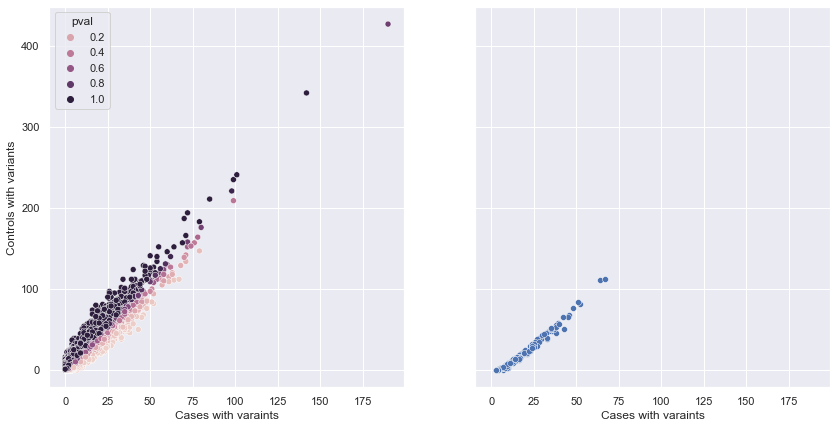

In [9]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
ax1 = sns.scatterplot(burden_test.pos_cases, burden_test.pos_controls, hue=burden_test.pval, ax=axes[0])
ax1.set_ylabel("Controls with variants")
ax1.set_xlabel("Cases with varaints")
ax2 = sns.scatterplot(significant_genes.pos_cases, significant_genes.pos_controls, ax=axes[1])
ax2.set_ylabel("Controls with variants")
ax2.set_xlabel("Cases with varaints")

Where there are fewer variants overall, it is more difficult to be confident that an observed effect is true, even with a significant p-value. For example, if 3 cases and 1 control have a variant in a gene is that a true effect or just random? We do not have coverage information available, so we have to assume that a reference call at a position is from sufficient data, and is not actually missing because there was no coverage. This makes interpreting varaints with low varaint counts risky - as a single missed variant may be enough to change a result to significant.

The following histogram shows the distribution of the total number of variant samples (i.e. pos controls + pos cases) per gene. We can see that the majority of genes have relatively few samples with variants, suggesting that they may be less reliable.

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Total significant genes: 226
42 genes with <10 variant samples
87 genes with <10 variant samples
141 genes with <25 variant samples
182 genes with <50 variant samples
218 genes with <100 variant samples


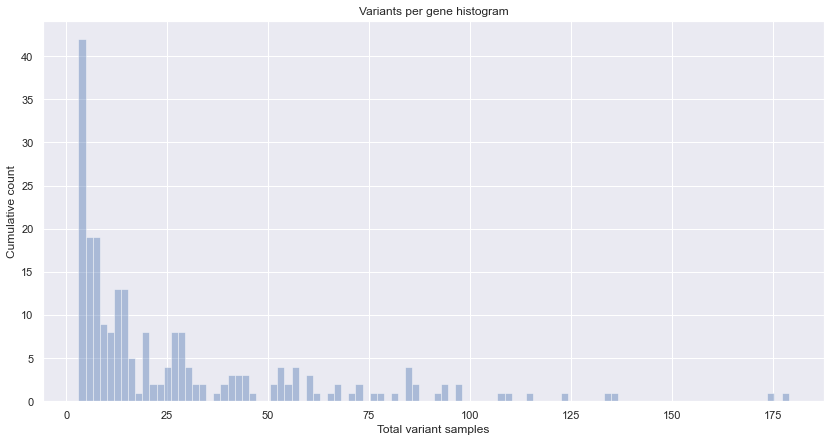

In [10]:
f, axes = plt.subplots(figsize=(14, 7))
ax1 = sns.distplot(significant_genes.total_pos, norm_hist=False, kde=False, bins=100)
ax1.set_title("Variants per gene histogram")
ax1.set_ylabel("Cumulative count")
ax1.set_xlabel("Total variant samples")

print(f"Total significant genes: {significant_genes.shape[0]}", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 5].shape[0]} genes with <10 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 10].shape[0]} genes with <10 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 25].shape[0]} genes with <25 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 50].shape[0]} genes with <50 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 100].shape[0]} genes with <100 variant samples", file=sys.stderr)

Viewing this as a cumulative plot, we can see that ~50% of all genes have fewer than 25 samples with variants (both cases and controls).

p-value show a much more uniform distribution

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Cumulative frequency')

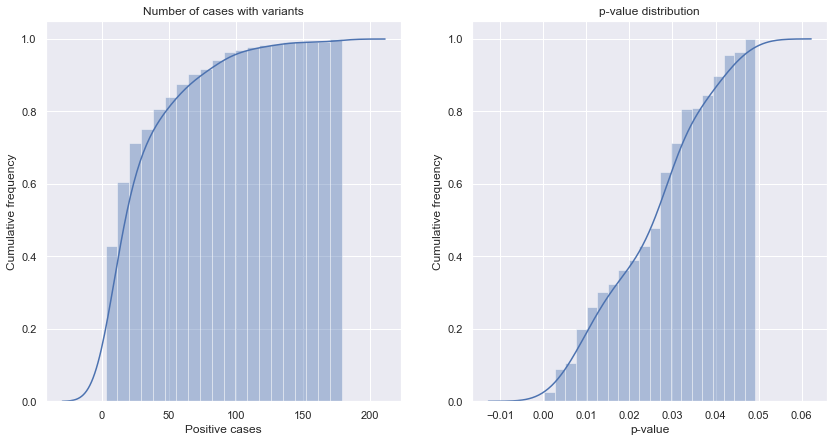

In [11]:
f, axes = plt.subplots(1, 2, figsize=(14, 7))

kwargs = {'cumulative': True}
ax1 = sns.distplot(significant_genes.total_pos, hist_kws=kwargs, kde_kws=kwargs, ax=axes[0], bins=20)
ax1.set_title("Number of cases with variants")
ax1.set_xlabel("Positive cases")
ax1.set_ylabel("Cumulative frequency")
ax2 = sns.distplot(significant_genes.pval, hist_kws=kwargs, kde_kws=kwargs, ax=axes[1], bins=20)
ax2.set_title("p-value distribution")
ax2.set_xlabel("p-value")
ax2.set_ylabel("Cumulative frequency")

In [13]:
from functions import get_latest_symbol_from_hgnc, get_chromosome

# Load the smaller trimmed dataframe if it's available
try:
    hgnc_checked = pd.read_pickle("Processed_data/hgnc_checked.pickle")
    print("Loaded HGNC checked data from file.", file=sys.stderr)
except FileNotFoundError:
    # Load the processed data from the previous step
    hgnc_checked = burden_test
    hgnc_checked['HGNC'] = hgnc_checked.GENE.progress_map(get_latest_symbol_from_hgnc)
    # Drop any genes without HGNC IDs
    hgnc_checked = hgnc_checked.dropna()
    # Find the chromsome
    hgnc_checked['CHROM'] = hgnc_checked.HGNC.progress_map(get_chromosome)
    # Add the log10 of the pval
    hgnc_checked['logp'] = -np.log10(hgnc_checked['pval'])
    # Chromosome order (for ordered categorical data type)
    chromorder = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
              "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"]
    # Set CHROM as ordered categorical, so that the Manhattan plot knows the correct
    hgnc_checked['CHROM'] = hgnc_checked['CHROM'].astype(pd.CategoricalDtype(chromorder, ordered=True))
    # Write processed data to Pickle.
    hgnc_checked.to_pickle("Processed_data/hgnc_checked.pickle")
    print("Checked gene symbols against HGNC IDs, and saved processed data.", file=sys.stderr)

ERROR: gene AC002472.13 does not have an HGNC ID
ERROR: gene AC003101.1 does not have an HGNC ID
ERROR: gene AC004381.6 does not have an HGNC ID
ERROR: gene AC005477.1 does not have an HGNC ID
ERROR: gene AC005609.1 does not have an HGNC ID
ERROR: gene AC005841.1 does not have an HGNC ID
ERROR: gene AC006435.1 does not have an HGNC ID
ERROR: gene AC006486.1 does not have an HGNC ID
ERROR: gene AC006538.4 does not have an HGNC ID
ERROR: gene AC006547.14 does not have an HGNC ID
ERROR: gene AC007956.1 does not have an HGNC ID
ERROR: gene AC009041.2 does not have an HGNC ID
ERROR: gene AC009365.3 does not have an HGNC ID
ERROR: gene AC011239.1 does not have an HGNC ID
ERROR: gene AC011475.1 does not have an HGNC ID
ERROR: gene AC012123.1 does not have an HGNC ID
ERROR: gene AC012313.1 does not have an HGNC ID
ERROR: gene AC012493.2 does not have an HGNC ID
ERROR: gene AC016251.1 does not have an HGNC ID
ERROR: gene AC019294.1 does not have an HGNC ID
ERROR: gene AC020907.1 does not have a

ERROR: Something went wrong checking HGNC for gene HGNC:9843
ERROR: Something went wrong checking HGNC for gene HGNC:9845
ERROR: Something went wrong checking HGNC for gene HGNC:9847
ERROR: Something went wrong checking HGNC for gene HGNC:29285
ERROR: Something went wrong checking HGNC for gene HGNC:14428
ERROR: Something went wrong checking HGNC for gene HGNC:9848
ERROR: Something went wrong checking HGNC for gene HGNC:9850
ERROR: Something went wrong checking HGNC for gene HGNC:26353
ERROR: Something went wrong checking HGNC for gene HGNC:9851
ERROR: Something went wrong checking HGNC for gene HGNC:13727
ERROR: Something went wrong checking HGNC for gene HGNC:9854
ERROR: Something went wrong checking HGNC for gene HGNC:17679
ERROR: Something went wrong checking HGNC for gene HGNC:9855
ERROR: Something went wrong checking HGNC for gene HGNC:9858
ERROR: Something went wrong checking HGNC for gene HGNC:29176
ERROR: Something went wrong checking HGNC for gene HGNC:9859
ERROR: Something w

ERROR: Something went wrong checking HGNC for gene HGNC:40912
ERROR: Something went wrong checking HGNC for gene HGNC:19975
ERROR: Something went wrong checking HGNC for gene HGNC:17964
ERROR: Something went wrong checking HGNC for gene HGNC:19978
ERROR: Something went wrong checking HGNC for gene HGNC:19979
ERROR: Something went wrong checking HGNC for gene HGNC:29674
ERROR: Something went wrong checking HGNC for gene HGNC:9940
ERROR: Something went wrong checking HGNC for gene HGNC:14423
ERROR: Something went wrong checking HGNC for gene HGNC:19950
ERROR: Something went wrong checking HGNC for gene HGNC:9944
ERROR: Something went wrong checking HGNC for gene HGNC:16879
ERROR: Something went wrong checking HGNC for gene HGNC:11345
ERROR: Something went wrong checking HGNC for gene HGNC:9948
ERROR: Something went wrong checking HGNC for gene HGNC:9949
ERROR: Something went wrong checking HGNC for gene HGNC:9950
ERROR: Something went wrong checking HGNC for gene HGNC:17975
ERROR: Someth

ERROR: Something went wrong checking HGNC for gene HGNC:18656
ERROR: Something went wrong checking HGNC for gene HGNC:18999
ERROR: Something went wrong checking HGNC for gene HGNC:11451
ERROR: Something went wrong checking HGNC for gene HGNC:10019
ERROR: Something went wrong checking HGNC for gene HGNC:10020
ERROR: Something went wrong checking HGNC for gene HGNC:10021
ERROR: Something went wrong checking HGNC for gene HGNC:496
ERROR: Something went wrong checking HGNC for gene HGNC:10023
ERROR: Something went wrong checking HGNC for gene HGNC:10017
ERROR: Something went wrong checking HGNC for gene HGNC:25925
ERROR: Something went wrong checking HGNC for gene HGNC:10024
ERROR: Something went wrong checking HGNC for gene HGNC:10025
ERROR: Something went wrong checking HGNC for gene HGNC:10026
ERROR: Something went wrong checking HGNC for gene HGNC:17135
ERROR: Something went wrong checking HGNC for gene HGNC:27089
ERROR: Something went wrong checking HGNC for gene HGNC:24285
ERROR: Som

ERROR: Something went wrong checking HGNC for gene HGNC:20870
ERROR: Something went wrong checking HGNC for gene HGNC:13436
ERROR: Something went wrong checking HGNC for gene HGNC:29168
ERROR: Something went wrong checking HGNC for gene HGNC:17056
ERROR: Something went wrong checking HGNC for gene HGNC:10296
ERROR: Something went wrong checking HGNC for gene HGNC:10301
ERROR: Something went wrong checking HGNC for gene HGNC:10303
ERROR: Something went wrong checking HGNC for gene HGNC:10304
ERROR: Something went wrong checking HGNC for gene HGNC:10310
ERROR: Something went wrong checking HGNC for gene HGNC:27610
ERROR: Something went wrong checking HGNC for gene HGNC:10316
ERROR: Something went wrong checking HGNC for gene HGNC:10325
ERROR: Something went wrong checking HGNC for gene HGNC:10328
ERROR: Something went wrong checking HGNC for gene HGNC:10332
ERROR: Something went wrong checking HGNC for gene HGNC:10334
ERROR: Something went wrong checking HGNC for gene HGNC:10359
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:10487
ERROR: Something went wrong checking HGNC for gene HGNC:10488
ERROR: Something went wrong checking HGNC for gene HGNC:20441
ERROR: Something went wrong checking HGNC for gene HGNC:10493
ERROR: Something went wrong checking HGNC for gene HGNC:10494
ERROR: Something went wrong checking HGNC for gene HGNC:10495
ERROR: Something went wrong checking HGNC for gene HGNC:25768
ERROR: Something went wrong checking HGNC for gene HGNC:30367
ERROR: Something went wrong checking HGNC for gene HGNC:3169
ERROR: Something went wrong checking HGNC for gene HGNC:3167
ERROR: Something went wrong checking HGNC for gene HGNC:3170
ERROR: Something went wrong checking HGNC for gene HGNC:14299
ERROR: Something went wrong checking HGNC for gene HGNC:10514
ERROR: Something went wrong checking HGNC for gene HGNC:10516
ERROR: Something went wrong checking HGNC for gene HGNC:25158
ERROR: Something went wrong checking HGNC for gene HGNC:30179
ERROR: Some

ERROR: Something went wrong checking HGNC for gene HGNC:25537
ERROR: Something went wrong checking HGNC for gene HGNC:10659
ERROR: Something went wrong checking HGNC for gene HGNC:10660
ERROR: Something went wrong checking HGNC for gene HGNC:10661
ERROR: Something went wrong checking HGNC for gene HGNC:10662
ERROR: Something went wrong checking HGNC for gene HGNC:15756
ERROR: Something went wrong checking HGNC for gene HGNC:10667
ERROR: Something went wrong checking HGNC for gene HGNC:10671
ERROR: Something went wrong checking HGNC for gene HGNC:26643
ERROR: Something went wrong checking HGNC for gene HGNC:10675
ERROR: Something went wrong checking HGNC for gene HGNC:10676
ERROR: Something went wrong checking HGNC for gene HGNC:24188
ERROR: Something went wrong checking HGNC for gene HGNC:10680
ERROR: Something went wrong checking HGNC for gene HGNC:10681
ERROR: Something went wrong checking HGNC for gene HGNC:10682
ERROR: Something went wrong checking HGNC for gene HGNC:19307
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:1258
ERROR: Something went wrong checking HGNC for gene HGNC:25566
ERROR: Something went wrong checking HGNC for gene HGNC:26116
ERROR: Something went wrong checking HGNC for gene HGNC:30412
ERROR: Something went wrong checking HGNC for gene HGNC:29489
ERROR: Something went wrong checking HGNC for gene HGNC:28508
ERROR: Something went wrong checking HGNC for gene HGNC:10761
ERROR: Something went wrong checking HGNC for gene HGNC:20263
ERROR: Something went wrong checking HGNC for gene HGNC:10762
ERROR: Something went wrong checking HGNC for gene HGNC:445
ERROR: Something went wrong checking HGNC for gene HGNC:15955
ERROR: Something went wrong checking HGNC for gene HGNC:10763
ERROR: Something went wrong checking HGNC for gene HGNC:30844
ERROR: Something went wrong checking HGNC for gene HGNC:12950
ERROR: Something went wrong checking HGNC for gene HGNC:10765
ERROR: Something went wrong checking HGNC for gene HGNC:10766
ERROR: Some

ERROR: Something went wrong checking HGNC for gene HGNC:10883
ERROR: Something went wrong checking HGNC for gene HGNC:24779
ERROR: Something went wrong checking HGNC for gene HGNC:19353
ERROR: Something went wrong checking HGNC for gene HGNC:19354
ERROR: Something went wrong checking HGNC for gene HGNC:10885
ERROR: Something went wrong checking HGNC for gene HGNC:20284
ERROR: Something went wrong checking HGNC for gene HGNC:23800
ERROR: Something went wrong checking HGNC for gene HGNC:23801
ERROR: Something went wrong checking HGNC for gene HGNC:9662
ERROR: Something went wrong checking HGNC for gene HGNC:15928
ERROR: Something went wrong checking HGNC for gene HGNC:16247
ERROR: Something went wrong checking HGNC for gene HGNC:15757
ERROR: Something went wrong checking HGNC for gene HGNC:14929
ERROR: Something went wrong checking HGNC for gene HGNC:10886
ERROR: Something went wrong checking HGNC for gene HGNC:14931
ERROR: Something went wrong checking HGNC for gene HGNC:14932
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:10975
ERROR: Something went wrong checking HGNC for gene HGNC:10976
ERROR: Something went wrong checking HGNC for gene HGNC:10977
ERROR: Something went wrong checking HGNC for gene HGNC:10978
ERROR: Something went wrong checking HGNC for gene HGNC:20611
ERROR: Something went wrong checking HGNC for gene HGNC:10980
ERROR: Something went wrong checking HGNC for gene HGNC:10981
ERROR: Something went wrong checking HGNC for gene HGNC:10982
ERROR: Something went wrong checking HGNC for gene HGNC:10983
ERROR: Something went wrong checking HGNC for gene HGNC:10985
ERROR: Something went wrong checking HGNC for gene HGNC:10986
ERROR: Something went wrong checking HGNC for gene HGNC:10987
ERROR: Something went wrong checking HGNC for gene HGNC:10988
ERROR: Something went wrong checking HGNC for gene HGNC:22921
ERROR: Something went wrong checking HGNC for gene HGNC:1421
ERROR: Something went wrong checking HGNC for gene HGNC:14411
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:20862
ERROR: Something went wrong checking HGNC for gene HGNC:20182
ERROR: Something went wrong checking HGNC for gene HGNC:11025
ERROR: Something went wrong checking HGNC for gene HGNC:11026
ERROR: Something went wrong checking HGNC for gene HGNC:10909
ERROR: Something went wrong checking HGNC for gene HGNC:19429
ERROR: Something went wrong checking HGNC for gene HGNC:31046
ERROR: Something went wrong checking HGNC for gene HGNC:9225
ERROR: Something went wrong checking HGNC for gene HGNC:23087
ERROR: Something went wrong checking HGNC for gene HGNC:17466
ERROR: Something went wrong checking HGNC for gene HGNC:18798
ERROR: Something went wrong checking HGNC for gene HGNC:17292
ERROR: Something went wrong checking HGNC for gene HGNC:28689
ERROR: Something went wrong checking HGNC for gene HGNC:13941
ERROR: Something went wrong checking HGNC for gene HGNC:28524
ERROR: Something went wrong checking HGNC for gene HGNC:17939
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:11102
ERROR: Something went wrong checking HGNC for gene HGNC:11104
ERROR: Something went wrong checking HGNC for gene HGNC:11105
ERROR: Something went wrong checking HGNC for gene HGNC:11107
ERROR: Something went wrong checking HGNC for gene HGNC:11108
ERROR: Something went wrong checking HGNC for gene HGNC:11109
ERROR: Something went wrong checking HGNC for gene HGNC:11112
ERROR: Something went wrong checking HGNC for gene HGNC:14011
ERROR: Something went wrong checking HGNC for gene HGNC:2468
ERROR: Something went wrong checking HGNC for gene HGNC:14013
ERROR: Something went wrong checking HGNC for gene HGNC:20465
ERROR: Something went wrong checking HGNC for gene HGNC:20466
ERROR: Something went wrong checking HGNC for gene HGNC:29090
ERROR: Something went wrong checking HGNC for gene HGNC:27407
ERROR: Something went wrong checking HGNC for gene HGNC:34401
ERROR: Something went wrong checking HGNC for gene HGNC:24810
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:16698
ERROR: Something went wrong checking HGNC for gene HGNC:16699
ERROR: Something went wrong checking HGNC for gene HGNC:11184
ERROR: Something went wrong checking HGNC for gene HGNC:11185
ERROR: Something went wrong checking HGNC for gene HGNC:11186
ERROR: Something went wrong checking HGNC for gene HGNC:11187
ERROR: Something went wrong checking HGNC for gene HGNC:11188
ERROR: Something went wrong checking HGNC for gene HGNC:13771
ERROR: Something went wrong checking HGNC for gene HGNC:21748
ERROR: Something went wrong checking HGNC for gene HGNC:27033
ERROR: Something went wrong checking HGNC for gene HGNC:32958
ERROR: Something went wrong checking HGNC for gene HGNC:32960
ERROR: Something went wrong checking HGNC for gene HGNC:11189
ERROR: Something went wrong checking HGNC for gene HGNC:11190
ERROR: Something went wrong checking HGNC for gene HGNC:11191
ERROR: Something went wrong checking HGNC for gene HGNC:11192
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:29522
ERROR: Something went wrong checking HGNC for gene HGNC:30629
ERROR: Something went wrong checking HGNC for gene HGNC:11272
ERROR: Something went wrong checking HGNC for gene HGNC:11273
ERROR: Something went wrong checking HGNC for gene HGNC:11274
ERROR: Something went wrong checking HGNC for gene HGNC:11275
ERROR: Something went wrong checking HGNC for gene HGNC:11276
ERROR: Something went wrong checking HGNC for gene HGNC:14896
ERROR: Something went wrong checking HGNC for gene HGNC:15680
ERROR: Something went wrong checking HGNC for gene HGNC:11277
ERROR: Something went wrong checking HGNC for gene HGNC:11278
ERROR: Something went wrong checking HGNC for gene HGNC:16253
ERROR: Something went wrong checking HGNC for gene HGNC:20361
ERROR: Something went wrong checking HGNC for gene HGNC:26818
ERROR: Something went wrong checking HGNC for gene HGNC:30721
ERROR: Something went wrong checking HGNC for gene HGNC:11279
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:19205
ERROR: Something went wrong checking HGNC for gene HGNC:11387
ERROR: Something went wrong checking HGNC for gene HGNC:11388
ERROR: Something went wrong checking HGNC for gene HGNC:11389
ERROR: Something went wrong checking HGNC for gene HGNC:19184
ERROR: Something went wrong checking HGNC for gene HGNC:11394
ERROR: Something went wrong checking HGNC for gene HGNC:11395
ERROR: Something went wrong checking HGNC for gene HGNC:11396
ERROR: Something went wrong checking HGNC for gene HGNC:11398
ERROR: Something went wrong checking HGNC for gene HGNC:11403
ERROR: Something went wrong checking HGNC for gene HGNC:11404
ERROR: Something went wrong checking HGNC for gene HGNC:11406
ERROR: Something went wrong checking HGNC for gene HGNC:11407
ERROR: Something went wrong checking HGNC for gene HGNC:28317
ERROR: Something went wrong checking HGNC for gene HGNC:14217
ERROR: Something went wrong checking HGNC for gene HGNC:21332
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:11491
ERROR: Something went wrong checking HGNC for gene HGNC:22935
ERROR: Something went wrong checking HGNC for gene HGNC:11494
ERROR: Something went wrong checking HGNC for gene HGNC:11496
ERROR: Something went wrong checking HGNC for gene HGNC:28897
ERROR: Something went wrong checking HGNC for gene HGNC:16918
ERROR: Something went wrong checking HGNC for gene HGNC:15885
ERROR: Something went wrong checking HGNC for gene HGNC:32388
ERROR: Something went wrong checking HGNC for gene HGNC:17089
ERROR: Something went wrong checking HGNC for gene HGNC:17084
ERROR: Something went wrong checking HGNC for gene HGNC:19861
ERROR: Something went wrong checking HGNC for gene HGNC:26703
ERROR: Something went wrong checking HGNC for gene HGNC:11497
ERROR: Something went wrong checking HGNC for gene HGNC:11498
ERROR: Something went wrong checking HGNC for gene HGNC:11499
ERROR: Something went wrong checking HGNC for gene HGNC:11501
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:11578
ERROR: Something went wrong checking HGNC for gene HGNC:23609
ERROR: Something went wrong checking HGNC for gene HGNC:24510
ERROR: Something went wrong checking HGNC for gene HGNC:24702
ERROR: Something went wrong checking HGNC for gene HGNC:29082
ERROR: Something went wrong checking HGNC for gene HGNC:29246
ERROR: Something went wrong checking HGNC for gene HGNC:25694
ERROR: Something went wrong checking HGNC for gene HGNC:28356
ERROR: Something went wrong checking HGNC for gene HGNC:25699
ERROR: Something went wrong checking HGNC for gene HGNC:25624
ERROR: Something went wrong checking HGNC for gene HGNC:18026
ERROR: Something went wrong checking HGNC for gene HGNC:16133
ERROR: Something went wrong checking HGNC for gene HGNC:28536
ERROR: Something went wrong checking HGNC for gene HGNC:1309
ERROR: Something went wrong checking HGNC for gene HGNC:21602
ERROR: Something went wrong checking HGNC for gene HGNC:25622
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:37242
ERROR: Something went wrong checking HGNC for gene HGNC:19737
ERROR: Something went wrong checking HGNC for gene HGNC:8117
ERROR: Something went wrong checking HGNC for gene HGNC:29943
ERROR: Something went wrong checking HGNC for gene HGNC:29944
ERROR: Something went wrong checking HGNC for gene HGNC:29945
ERROR: Something went wrong checking HGNC for gene HGNC:11726
ERROR: Something went wrong checking HGNC for gene HGNC:11729
ERROR: Something went wrong checking HGNC for gene HGNC:19246
ERROR: Something went wrong checking HGNC for gene HGNC:14620
ERROR: Something went wrong checking HGNC for gene HGNC:11731
ERROR: Something went wrong checking HGNC for gene HGNC:11732
ERROR: Something went wrong checking HGNC for gene HGNC:29109
ERROR: Something went wrong checking HGNC for gene HGNC:29484
ERROR: Something went wrong checking HGNC for gene HGNC:25941
ERROR: Something went wrong checking HGNC for gene HGNC:28313
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:17317
ERROR: Something went wrong checking HGNC for gene HGNC:17316
ERROR: Something went wrong checking HGNC for gene HGNC:23656
ERROR: Something went wrong checking HGNC for gene HGNC:11818
ERROR: Something went wrong checking HGNC for gene HGNC:11819
ERROR: Something went wrong checking HGNC for gene HGNC:1321
ERROR: Something went wrong checking HGNC for gene HGNC:11820
ERROR: Something went wrong checking HGNC for gene HGNC:11821
ERROR: Something went wrong checking HGNC for gene HGNC:11822
ERROR: Something went wrong checking HGNC for gene HGNC:14599
ERROR: Something went wrong checking HGNC for gene HGNC:19168
ERROR: Something went wrong checking HGNC for gene HGNC:11824
ERROR: Something went wrong checking HGNC for gene HGNC:23696
ERROR: Something went wrong checking HGNC for gene HGNC:30750
ERROR: Something went wrong checking HGNC for gene HGNC:17192
ERROR: Something went wrong checking HGNC for gene HGNC:17949
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:27031
ERROR: Something went wrong checking HGNC for gene HGNC:27962
ERROR: Something went wrong checking HGNC for gene HGNC:28187
ERROR: Something went wrong checking HGNC for gene HGNC:28709
ERROR: Something went wrong checking HGNC for gene HGNC:24930
ERROR: Something went wrong checking HGNC for gene HGNC:29596
ERROR: Something went wrong checking HGNC for gene HGNC:28143
ERROR: Something went wrong checking HGNC for gene HGNC:28517
ERROR: Something went wrong checking HGNC for gene HGNC:44112
ERROR: Something went wrong checking HGNC for gene HGNC:20137
ERROR: Something went wrong checking HGNC for gene HGNC:33744
ERROR: Something went wrong checking HGNC for gene HGNC:26196
ERROR: Something went wrong checking HGNC for gene HGNC:20958
ERROR: Something went wrong checking HGNC for gene HGNC:26391
ERROR: Something went wrong checking HGNC for gene HGNC:20173
ERROR: Something went wrong checking HGNC for gene HGNC:28797
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:29994
ERROR: Something went wrong checking HGNC for gene HGNC:28779
ERROR: Something went wrong checking HGNC for gene HGNC:29808
ERROR: Something went wrong checking HGNC for gene HGNC:9490
ERROR: Something went wrong checking HGNC for gene HGNC:11876
ERROR: Something went wrong checking HGNC for gene HGNC:11877
ERROR: Something went wrong checking HGNC for gene HGNC:11878
ERROR: Something went wrong checking HGNC for gene HGNC:14908
ERROR: Something went wrong checking HGNC for gene HGNC:16517
ERROR: Something went wrong checking HGNC for gene HGNC:30846
ERROR: Something went wrong checking HGNC for gene HGNC:30079
ERROR: Something went wrong checking HGNC for gene HGNC:30744
ERROR: Something went wrong checking HGNC for gene HGNC:24099
ERROR: Something went wrong checking HGNC for gene HGNC:25440
ERROR: Something went wrong checking HGNC for gene HGNC:26899
ERROR: Something went wrong checking HGNC for gene HGNC:25904
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:12016
ERROR: Something went wrong checking HGNC for gene HGNC:19293
ERROR: Something went wrong checking HGNC for gene HGNC:24162
ERROR: Something went wrong checking HGNC for gene HGNC:12017
ERROR: Something went wrong checking HGNC for gene HGNC:30413
ERROR: Something went wrong checking HGNC for gene HGNC:24759
ERROR: Something went wrong checking HGNC for gene HGNC:27007
ERROR: Something went wrong checking HGNC for gene HGNC:26894
ERROR: Something went wrong checking HGNC for gene HGNC:14118
ERROR: Something went wrong checking HGNC for gene HGNC:14134
ERROR: Something went wrong checking HGNC for gene HGNC:12020
ERROR: Something went wrong checking HGNC for gene HGNC:12021
ERROR: Something went wrong checking HGNC for gene HGNC:12023
ERROR: Something went wrong checking HGNC for gene HGNC:17299
ERROR: Something went wrong checking HGNC for gene HGNC:1249
ERROR: Something went wrong checking HGNC for gene HGNC:16645
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:19019
ERROR: Something went wrong checking HGNC for gene HGNC:19020
ERROR: Something went wrong checking HGNC for gene HGNC:16276
ERROR: Something went wrong checking HGNC for gene HGNC:19017
ERROR: Something went wrong checking HGNC for gene HGNC:19023
ERROR: Something went wrong checking HGNC for gene HGNC:16008
ERROR: Something went wrong checking HGNC for gene HGNC:14215
ERROR: Something went wrong checking HGNC for gene HGNC:19028
ERROR: Something went wrong checking HGNC for gene HGNC:24150
ERROR: Something went wrong checking HGNC for gene HGNC:30834
ERROR: Something went wrong checking HGNC for gene HGNC:16277
ERROR: Something went wrong checking HGNC for gene HGNC:33440
ERROR: Something went wrong checking HGNC for gene HGNC:21162
ERROR: Something went wrong checking HGNC for gene HGNC:25574
ERROR: Something went wrong checking HGNC for gene HGNC:16007
ERROR: Something went wrong checking HGNC for gene HGNC:27316
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:11401
ERROR: Something went wrong checking HGNC for gene HGNC:15473
ERROR: Something went wrong checking HGNC for gene HGNC:19825
ERROR: Something went wrong checking HGNC for gene HGNC:30410
ERROR: Something went wrong checking HGNC for gene HGNC:12388
ERROR: Something went wrong checking HGNC for gene HGNC:12390
ERROR: Something went wrong checking HGNC for gene HGNC:35410
ERROR: Something went wrong checking HGNC for gene HGNC:30087
ERROR: Something went wrong checking HGNC for gene HGNC:19140
ERROR: Something went wrong checking HGNC for gene HGNC:19141
ERROR: Something went wrong checking HGNC for gene HGNC:12391
ERROR: Something went wrong checking HGNC for gene HGNC:23700
ERROR: Something went wrong checking HGNC for gene HGNC:26204
ERROR: Something went wrong checking HGNC for gene HGNC:24697
ERROR: Something went wrong checking HGNC for gene HGNC:26536
ERROR: Something went wrong checking HGNC for gene HGNC:25596
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:17598
ERROR: Something went wrong checking HGNC for gene HGNC:12491
ERROR: Something went wrong checking HGNC for gene HGNC:29554
ERROR: Something went wrong checking HGNC for gene HGNC:19248
ERROR: Something went wrong checking HGNC for gene HGNC:19907
ERROR: Something went wrong checking HGNC for gene HGNC:25009
ERROR: Something went wrong checking HGNC for gene HGNC:28559
ERROR: Something went wrong checking HGNC for gene HGNC:25616
ERROR: Something went wrong checking HGNC for gene HGNC:12496
ERROR: Something went wrong checking HGNC for gene HGNC:13478
ERROR: Something went wrong checking HGNC for gene HGNC:16803
ERROR: Something went wrong checking HGNC for gene HGNC:21381
ERROR: Something went wrong checking HGNC for gene HGNC:12499
ERROR: Something went wrong checking HGNC for gene HGNC:12500
ERROR: Something went wrong checking HGNC for gene HGNC:30565
ERROR: Something went wrong checking HGNC for gene HGNC:30791
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:12609
ERROR: Something went wrong checking HGNC for gene HGNC:12611
ERROR: Something went wrong checking HGNC for gene HGNC:12612
ERROR: Something went wrong checking HGNC for gene HGNC:12614
ERROR: Something went wrong checking HGNC for gene HGNC:12617
ERROR: Something went wrong checking HGNC for gene HGNC:12618
ERROR: Something went wrong checking HGNC for gene HGNC:12619
ERROR: Something went wrong checking HGNC for gene HGNC:12620
ERROR: Something went wrong checking HGNC for gene HGNC:12621
ERROR: Something went wrong checking HGNC for gene HGNC:12623
ERROR: Something went wrong checking HGNC for gene HGNC:12624
ERROR: Something went wrong checking HGNC for gene HGNC:12625
ERROR: Something went wrong checking HGNC for gene HGNC:18563
ERROR: Something went wrong checking HGNC for gene HGNC:12626
ERROR: Something went wrong checking HGNC for gene HGNC:20065
ERROR: Something went wrong checking HGNC for gene HGNC:20060
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:26078
ERROR: Something went wrong checking HGNC for gene HGNC:27111
ERROR: Something went wrong checking HGNC for gene HGNC:32063
ERROR: Something went wrong checking HGNC for gene HGNC:28499
ERROR: Something went wrong checking HGNC for gene HGNC:33595
ERROR: Something went wrong checking HGNC for gene HGNC:16096
ERROR: Something went wrong checking HGNC for gene HGNC:26470
ERROR: Something went wrong checking HGNC for gene HGNC:34443
ERROR: Something went wrong checking HGNC for gene HGNC:12723
ERROR: Something went wrong checking HGNC for gene HGNC:1975
ERROR: Something went wrong checking HGNC for gene HGNC:20954
ERROR: Something went wrong checking HGNC for gene HGNC:28873
ERROR: Something went wrong checking HGNC for gene HGNC:17792
ERROR: Something went wrong checking HGNC for gene HGNC:17793
ERROR: Something went wrong checking HGNC for gene HGNC:12724
ERROR: Something went wrong checking HGNC for gene HGNC:24709
ERROR: So

ERROR: Something went wrong checking HGNC for gene HGNC:24785
ERROR: Something went wrong checking HGNC for gene HGNC:16959
ERROR: Something went wrong checking HGNC for gene HGNC:17798
ERROR: Something went wrong checking HGNC for gene HGNC:12843
ERROR: Something went wrong checking HGNC for gene HGNC:25035
ERROR: Something went wrong checking HGNC for gene HGNC:18327
ERROR: Something went wrong checking HGNC for gene HGNC:28905
ERROR: Something went wrong checking HGNC for gene HGNC:30626
ERROR: Something went wrong checking HGNC for gene HGNC:24721
ERROR: Something went wrong checking HGNC for gene HGNC:15867
ERROR: Something went wrong checking HGNC for gene HGNC:31675
ERROR: Something went wrong checking HGNC for gene HGNC:12849
ERROR: Something went wrong checking HGNC for gene HGNC:12856
ERROR: Something went wrong checking HGNC for gene HGNC:30935
ERROR: Something went wrong checking HGNC for gene HGNC:29504
ERROR: Something went wrong checking HGNC for gene HGNC:28697
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:15940
ERROR: Something went wrong checking HGNC for gene HGNC:24708
ERROR: Something went wrong checking HGNC for gene HGNC:28053
ERROR: Something went wrong checking HGNC for gene HGNC:28682
ERROR: Something went wrong checking HGNC for gene HGNC:14983
ERROR: Something went wrong checking HGNC for gene HGNC:12868
ERROR: Something went wrong checking HGNC for gene HGNC:19762
ERROR: Something went wrong checking HGNC for gene HGNC:16700
ERROR: Something went wrong checking HGNC for gene HGNC:17277
ERROR: Something went wrong checking HGNC for gene HGNC:29189
ERROR: Something went wrong checking HGNC for gene HGNC:12869
ERROR: Something went wrong checking HGNC for gene HGNC:13180
ERROR: Something went wrong checking HGNC for gene HGNC:20756
ERROR: Something went wrong checking HGNC for gene HGNC:20758
ERROR: Something went wrong checking HGNC for gene HGNC:20759
ERROR: Something went wrong checking HGNC for gene HGNC:20760
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:13847
ERROR: Something went wrong checking HGNC for gene HGNC:13507
ERROR: Something went wrong checking HGNC for gene HGNC:13578
ERROR: Something went wrong checking HGNC for gene HGNC:13644
ERROR: Something went wrong checking HGNC for gene HGNC:13842
ERROR: Something went wrong checking HGNC for gene HGNC:14096
ERROR: Something went wrong checking HGNC for gene HGNC:14104
ERROR: Something went wrong checking HGNC for gene HGNC:15462
ERROR: Something went wrong checking HGNC for gene HGNC:15624
ERROR: Something went wrong checking HGNC for gene HGNC:15806
ERROR: Something went wrong checking HGNC for gene HGNC:15807
ERROR: Something went wrong checking HGNC for gene HGNC:15809
ERROR: Something went wrong checking HGNC for gene HGNC:13096
ERROR: Something went wrong checking HGNC for gene HGNC:13097
ERROR: Something went wrong checking HGNC for gene HGNC:15992
ERROR: Something went wrong checking HGNC for gene HGNC:16017
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:25879
ERROR: Something went wrong checking HGNC for gene HGNC:28192
ERROR: Something went wrong checking HGNC for gene HGNC:29238
ERROR: Something went wrong checking HGNC for gene HGNC:29003
ERROR: Something went wrong checking HGNC for gene HGNC:26687
ERROR: Something went wrong checking HGNC for gene HGNC:25827
ERROR: Something went wrong checking HGNC for gene HGNC:24722
ERROR: Something went wrong checking HGNC for gene HGNC:24740
ERROR: Something went wrong checking HGNC for gene HGNC:28062
ERROR: Something went wrong checking HGNC for gene HGNC:29416
ERROR: Something went wrong checking HGNC for gene HGNC:26910
ERROR: Something went wrong checking HGNC for gene HGNC:28742
ERROR: Something went wrong checking HGNC for gene HGNC:24787
ERROR: Something went wrong checking HGNC for gene HGNC:30958
ERROR: Something went wrong checking HGNC for gene HGNC:29084
ERROR: Something went wrong checking HGNC for gene HGNC:30571
ERROR: S

ERROR: Something went wrong checking HGNC for gene HGNC:13165
ERROR: Something went wrong checking HGNC for gene HGNC:13166
ERROR: Something went wrong checking HGNC for gene HGNC:13169
ERROR: Something went wrong checking HGNC for gene HGNC:13175
ERROR: Something went wrong checking HGNC for gene HGNC:29271
ERROR: Something went wrong checking HGNC for gene HGNC:1177
ERROR: Something went wrong checking HGNC for gene HGNC:26089
ERROR: Something went wrong checking HGNC for gene HGNC:13182
ERROR: Something went wrong checking HGNC for gene HGNC:18452
ERROR: Something went wrong checking HGNC for gene HGNC:18126
ERROR: Something went wrong checking HGNC for gene HGNC:17726
ERROR: Something went wrong checking HGNC for gene HGNC:13187
ERROR: Something went wrong checking HGNC for gene HGNC:13189
ERROR: Something went wrong checking HGNC for gene HGNC:15770
ERROR: Something went wrong checking HGNC for gene HGNC:15662
ERROR: Something went wrong checking HGNC for gene HGNC:20678
ERROR: So

Checked gene symbols against HGNC IDs, and saved processed data.


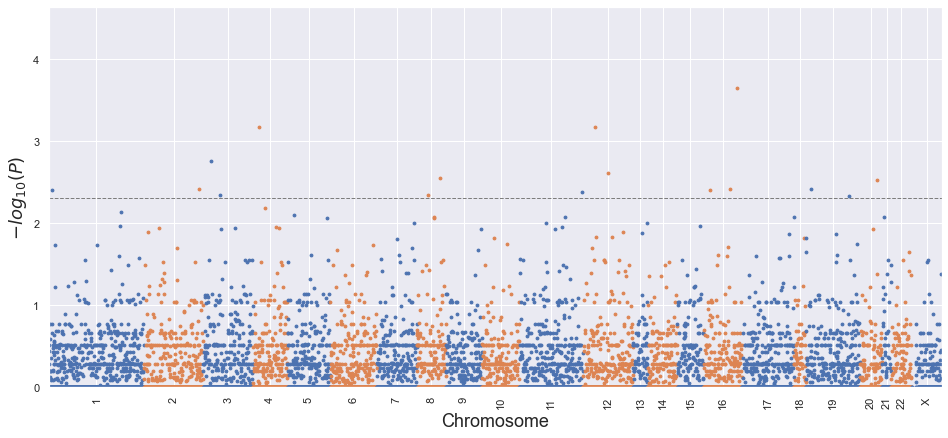

Current p-value threshold = 0.005 gives 20 significant genes.


In [14]:
# Manhattan plot

# WE need to make CHROM an ordered categorical data type
#hgnc_checked['CHROM'] = hgnc_checked['CHROM'].astype(pd.CategoricalDtype(chromorder, ordered=True))

from bioinfokit import analys, visuz

color = (sns.color_palette()[0], sns.color_palette()[1])
pval_threshold = 0.005
ax1 = visuz.marker.mhat(df=hgnc_checked, chr='CHROM', pv='pval', show=True, dim=(16,7), color=color, gwas_sign_line=True, gwasp=pval_threshold, axlabelfontsize=18, axxlabel="Chromosome")

print(f"Current p-value threshold = {pval_threshold} gives {hgnc_checked[hgnc_checked.pval <= pval_threshold].shape[0]} significant genes.", file=sys.stderr)

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


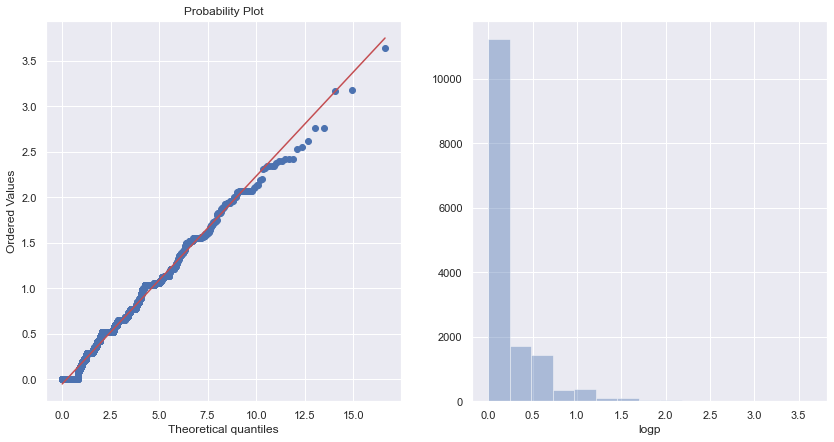

In [15]:
# QQ plot

# Distribution clearly isn't normal - in fact it seems most closely to fit the Chi^2 examples shown at https://www.sciencedirect.com/topics/mathematics/chi-square-distribution
# So use this dist for the QQ plot

# ?? correct number of DoF in this case? Looks like the plot for 1, and fits nicely, but that just feels like a guess...

measurements = hgnc_checked.logp  
f, axes = plt.subplots(1, 2, figsize=(14, 7))
ax1 = stats.probplot(measurements, dist=stats.chi2, sparams=(1,), fit=False, plot=axes[0])
ax2 = sns.distplot(hgnc_checked.logp, ax=axes[1], kde=False, norm_hist=False, bins=15)

In [16]:
df_variants = df_full[["CHROM", "POS", "ID", "GENE", "IMPACT", "HGVSc", "HGVSp", "SIFT", "Polyphen", "Condel", "GnomAD_AF", "ExAC_AF", "PHRED"]]

## Add in the per-gene pvalue
temp = hgnc_checked[['GENE', 'pval']]
df_variants = df_variants.join(temp.set_index("GENE"), on="GENE", rsuffix="-")
df_variants = df_variants[df_variants.PHRED >= 20]
# Get the top 5 most significant genes
top_genes = hgnc_checked[hgnc_checked.pval <= 0.005].sort_values("logp", ascending=False)['GENE']

# Extract the variants for these most significant genes
df_variants_filtered = df_variants[df_variants.GENE.isin(top_genes)]
df_variants_filtered = df_variants_filtered.drop_duplicates("ID")

print(f"Variants from significant genes: {df_variants_filtered.shape[0]}", file=sys.stderr)

# Write to an Excel file
df_variants_filtered.sort_values(['pval', 'POS']).to_excel("Processed_data/significant_variants.xlsx")

# OPT: output a list of genes and their p values
#hgnc_checked[['GENE', 'pval']].sort_values('pval').to_csv("Processed_data/genes_with_pvals.csv", header=False, index=False)

Variants from significant genes: 144
